This is a visualization of the first 10,000 jobs. Node size indicates in-degree (how many jobs come into this station). Node colors indicate the Line. Alpha of paths indicates how often jobs go from this station to another. One can nicely see parallel station setups and overflow / backup lines.


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: GGally

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

network: Classes for Relational Data
Version 1.13.0 created on 2015-08-31.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.

sna: Tools for Social Network Analysis
Version 2.3-2 created on 2014-01-13.
copyright (c

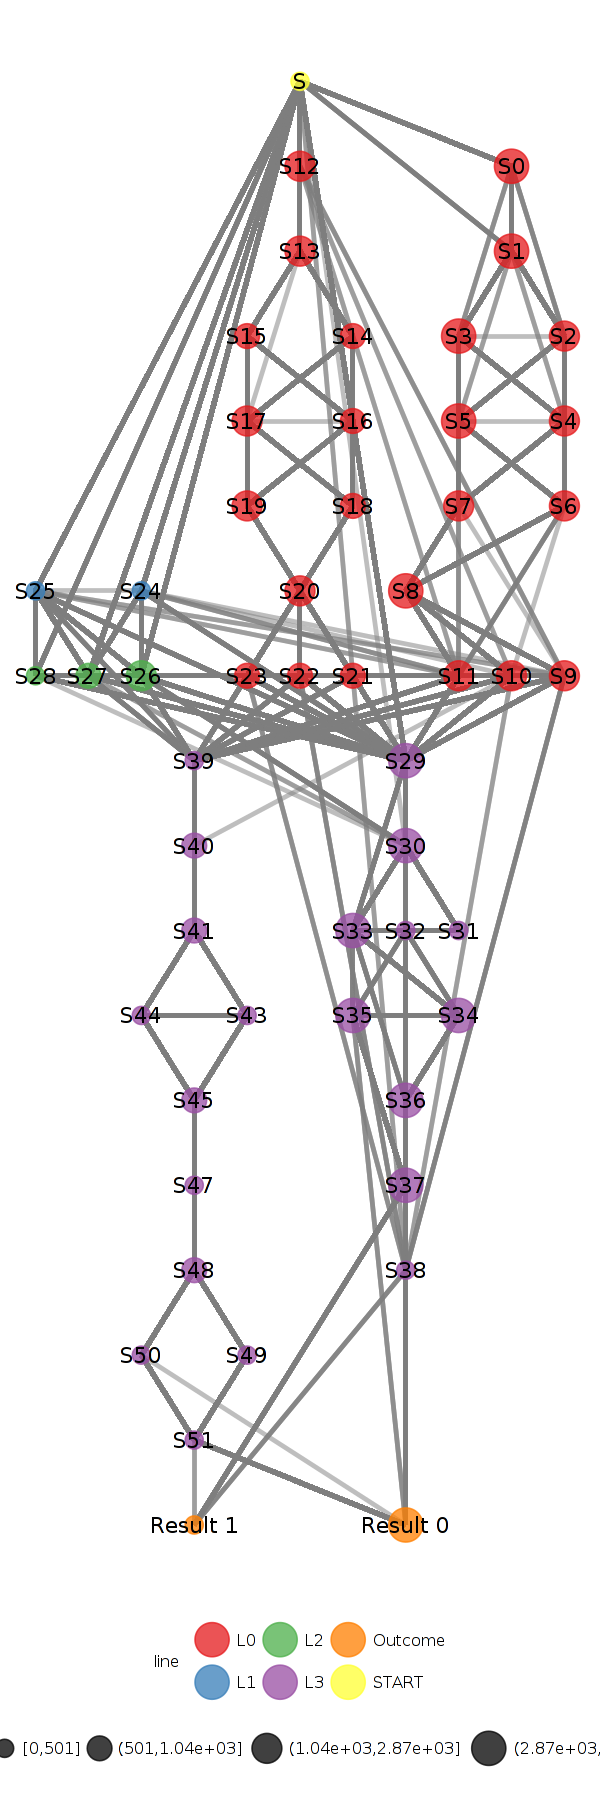

In [1]:
options(warn=-1) #surpress warnings

#imports for data wrangling
library(data.table)
library(dtplyr)
library(dplyr)

#get the data - nrows set to 10000 to keep runtime manageable.
#one expansion option would be to select a time frame to visualized
dtNum <- fread("../input/train_numeric.csv", select = c("Id", "Response"),nrows = 10000)
dtDate <- fread("../input/train_date.csv", nrows = 10000)

#for each job identify which stations are passed through and for those store the minimum time
for (station in paste0("S",0:51))
{
  cols = min(which((grepl(station,colnames(dtDate)))))
  if(!cols==Inf){
    dtDate[,paste0(station) := dtDate[,cols,with = FALSE]]
  }
}

#limit data to only when passed through station X
dtStations = dtDate[,!grepl("L",colnames(dtDate)),with=F]

#melt data to go from wide to long format
dtStationsM = melt(dtStations,id.vars=c("Id"))

#join with numeric to have Response
dtStationsM %>%
  left_join(dtNum, by = "Id") -> dtStationsM

#remove NA entries - these are plentiful as after melting each station-job combination has its own row
dtStationsM %>%
  filter(!is.na(value)) -> dtStationsMFiltered

#sort entries by ascending time
dtStationsMFiltered %>%
  arrange(value) -> dtStationsMFiltered

#imports for plotting
require(GGally)
library(network)
library(sna)
library(ggplot2)

#plotting format
options(repr.plot.width=5, repr.plot.height=15)

#for each row obtain the subsequent statoin
dtStationsMFiltered %>%
  group_by(Id) %>%
  mutate(nextStation = lead(variable)) -> edgelistsComplete

#for each id find the first node to be entered 
edgelistsComplete %>%
  group_by(Id) %>%
  filter(!(variable %in% nextStation)) %>%
  ungroup() %>%
  select(variable,Response) -> startingPoints

#prior to each starting point insert an edge from a common origin
colnames(startingPoints) = c("nextStation","Response")
startingPoints$variable = "S"
edgelistsComplete %>%
  select(variable,nextStation,Response) -> paths

#for each id find the row where there is no next station (last station to be visited)
#fill this station with Response value
paths[is.na(nextStation)]$nextStation = paste("Result",paths[is.na(nextStation)]$Response)

#combine data
paths = rbind(startingPoints,paths)
paths = select(paths,-Response)
paths$nextStation = as.character(paths$nextStation)
paths$variable = as.character(paths$variable)

#rename columns for plotting
colnames(paths) <- c("Target","Source")

#flip columns in a costly way because ggnet is a little dumb and I am lazy
pathshelp = select(paths,Source)
pathshelp$Target = paths$Target
paths=pathshelp

#create network from edgelist
net = network(as.data.frame(na.omit(paths)),
              directed = TRUE)

#create a station-line mapping lookup
LineStations = NULL
for (station in unique(paths$Source)){
  if(station!="S")
  {
  x=paste0("_",station,"_")
  y=head(colnames(dtDate)[which(grepl(x,colnames(dtDate)))],1)
  y=strsplit(y,"_")[[1]][1]
  LineStations = rbind(LineStations,data.frame(Node=station,Line=y))
  }
}
LineStations = rbind(LineStations,data.frame(Node=c("Result 1","Result 0","S"),Line=c("Outcome","Outcome","START")))

#merge station-line mapping into graph for coloring purposes
x = data.frame(Node = network.vertex.names(net))
x = merge(x, LineStations, by = "Node", sort = FALSE)$Line
net %v% "line" = as.character(x)

#setup station coordinates analogue to @JohnM
nodeCoordinates=data.frame(label=c("S","S0","S1","S2","S3","S4","S5","S6",
                                  "S7","S8","S9","S10","S11","S12","S13",
                                  "S14","S15","S16","S17","S18","S19",
                                  "S20","S21","S22","S23","S24","S25",
                                  "S26","S27","S28","S29","S30","S31",
                                  "S32","S33","S34","S35","S36","S37",
                                  "S38","S39","S40","S41","S43",
                                  "S44","S45","S47","S48","S49",
                                  "S50","S51","Result 0","Result 1"),
                           y=c(0,
                               1,2,3,3,4,4,5,5,6,7,7,7,
                               1,2,3,3,4,4,5,5,6,7,7,7,
                               6,6,7,7,7,
                               8,9,10,10,10,11,11,12,13,14,
                               8,9,10,11,11,12,13,14,15,15,16,
                               17,17),
                           x=c(5,
                               9,9,10,8,10,8,10,8,7,10,9,8,
                               5,5,6,4,6,4,6,4,5,6,5,4,
                               2,0,2,1,0,
                               7,7,8,7,6,8,6,7,7,7,
                               3,3,3,4,2,3,3,3,4,2,3,
                               7,3))

nodeCoordinates$y = -3 * nodeCoordinates$y

#setup initial plot
network = ggnet2(net)

#grab node list from initial plot and attach coordinates
netCoordinates = select(network$data,label)
netCoordinates = left_join(netCoordinates,nodeCoordinates,by = "label")
netCoordinates = as.matrix(select(netCoordinates,x,y))

#setup plot with manual layout
network = ggnet2(net,
                 alpha = 0.75, size = "indegree",
                 label = T, size.cut = 4,
                 color = "line",palette = "Set1",
                 mode = netCoordinates,
                 edge.alpha = 0.5, edge.size = 1,
                 legend.position = "bottom")


#output plot on graphics device
print(network)

It may for other analyses potentially be interesting which paths are used a lot. And which ones are used very seldom? Also which ones lead to Response=1 or Response=0?

In [2]:
#obtain summary statistic of number of edges on each station pair
pathshelp %>%
    mutate(stationpair=paste0(Source,"->",Target)) %>%
    group_by(stationpair) %>%
    summarize(count=n()) %>%
    arrange(-count) %>%
    print(n=10)

pathshelp %>%
    mutate(stationpair=paste0(Source,"->",Target)) %>%
    group_by(stationpair) %>%
    summarize(count=n()) %>%
    arrange(count) %>%
    print(n=10)

pathshelp %>%
    filter(Target=="Result 1") %>%
    mutate(stationpair=paste0(Source,"->",Target)) %>%
    group_by(stationpair) %>%
    summarize(count=n()) %>%
    arrange(count) %>%
    print(n=20)

pathshelp %>%
    filter(Target=="Result 0") %>%
    mutate(stationpair=paste0(Source,"->",Target)) %>%
    group_by(stationpair) %>%
    summarize(count=n()) %>%
    arrange(count) %>%
    print(n=20)

Source: local data table [162 x 2]

# tbl_dt [162 x 2]
     stationpair count
           <chr> <int>
1       S29->S30  9452
2       S33->S34  9421
3  S37->Result 0  9211
4       S30->S33  8977
5          S->S0  5733
6         S0->S1  5726
7       S36->S37  4827
8       S34->S36  4801
9       S35->S37  4646
10      S34->S35  4635
# ... with 152 more rows
Source: local data table [162 x 2]

# tbl_dt [162 x 2]
   stationpair count
         <chr> <int>
1       S->S30     1
2     S22->S23     1
3      S6->S10     1
4     S10->S40     1
5     S16->S17     1
6     S28->S30     1
7     S21->S23     1
8       S2->S3     1
9     S24->S25     1
10      S4->S5     1
# ... with 152 more rows
Source: local data table [3 x 2]

# tbl_dt [3 x 2]
    stationpair count
          <chr> <int>
1 S51->Result 1     2
2 S38->Result 1     4
3 S37->Result 1    47
Source: local data table [6 x 2]

# tbl_dt [6 x 2]
    stationpair count
          <chr> <int>
1 S50->Result 0     1
2 S35->Result 0     3
3 S36->Resul